In [19]:
import numpy as np
from pyrex.core import main
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from qcextender.dimensionlesswaveform import DimensionlessWaveform
from qcextender.waveform import Waveform
from qcextender import units

In [20]:
from pycbc.types import TimeSeries
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter.matchedfilter import make_frequency_series
from pycbc.filter import matched_filter_core,sigmasq
from pycbc.types import complex_same_precision_as
from scipy.interpolate import make_interp_spline
from qcextender.functions import spherical_harmonics

_snr = None
def modify_match(vec1, vec2, vec3, vec4, psd=None, low_frequency_cutoff=None,
          high_frequency_cutoff=None, v1_norm=None, v2_norm=None):
    """ Return the match between the two TimeSeries or FrequencySeries.

    Return the match between two waveforms. This is equivalent to the overlap
    maximized over time and phase.

    Parameters
    ----------
    vec1 : TimeSeries or FrequencySeries
        The input vector containing a waveform.
    vec2 : TimeSeries or FrequencySeries
        The input vector containing a waveform.
    psd : Frequency Series
        A power spectral density to weight the overlap.
    low_frequency_cutoff : {None, float}, optional
        The frequency to begin the match.
    high_frequency_cutoff : {None, float}, optional
        The frequency to stop the match.
    v1_norm : {None, float}, optional
        The normalization of the first waveform. This is equivalent to its
        sigmasq value. If None, it is internally calculated.
    v2_norm : {None, float}, optional
        The normalization of the second waveform. This is equivalent to its
        sigmasq value. If None, it is internally calculated.

    Returns
    -------
    match: float
    index: int
        The number of samples to shift to get the match.
    """
    
    htilde = make_frequency_series(vec1)    
    stilde = make_frequency_series(vec2)
    h_imag=make_frequency_series(vec3)*1j
    s_im=make_frequency_series(vec4)*1j
    htilde=htilde+h_imag
    stilde=stilde+s_im
    
    

    N = (len(htilde)-1) * 2

    global _snr
   
    if _snr is None or _snr.dtype != htilde.dtype or len(_snr) != N:
        _snr = np.zeros(N,dtype=complex_same_precision_as(vec1))
   
    snr, a, snr_norm = matched_filter_core(htilde,stilde,psd,low_frequency_cutoff,high_frequency_cutoff, v1_norm)
    maxsnr, max_id = snr.abs_max_loc()
    if v2_norm is None:
        v2_norm = sigmasq(stilde, psd, low_frequency_cutoff, high_frequency_cutoff)
    return maxsnr * snr_norm / np.sqrt(v2_norm), max_id



In [21]:
def resizeWave(time,strain,newtime,samplerate):  
    deltaT=1./samplerate
    newtime=np.arange(min(newtime),max(newtime),deltaT)
    inter_real=make_interp_spline(time,np.real(strain))
    inter_im=make_interp_spline(time,np.imag(strain))
    time_real=TimeSeries(inter_real(newtime),delta_t=deltaT)
    time_im=TimeSeries(inter_im(newtime),delta_t=deltaT)
    return time_real, time_im

def compute_match(testtime, testh, timemodel, mdlh, newtm, samplerate, f_max=None):
    nrdt,nid=resizeWave(testtime,testh,newtm,samplerate)
    mdt,mdi=resizeWave(timemodel,mdlh,newtm,samplerate)    
    f_lower=25.
    tlen=len(nrdt)
    delta_f = 1.0 / nrdt.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_lower)
    cmatch=modify_match(nrdt, mdt, nid, mdi, psd=psd, low_frequency_cutoff=f_lower, high_frequency_cutoff=f_max)
    return cmatch[0]

In [22]:
def complex_inner_prod(wave1, wave2, timebounds, samplerate, i1=0, i2=0):
    h1, h2 = [resizeWave(wave.time[i0:], wave[2,2][i0:], timebounds, samplerate) 
                                            for wave, i0 in zip((wave1, wave2), (i1, i2))]
    
    #return h1real, h1imag, h2real, h2imag
    
    h1 = np.real(h1) + 1.j * np.imag(h1)
    h2 = np.real(h2) + 1.j * np.imag(h2)
    return np.sum(h1 * np.conjugate(h2))



def complex_match(wave1, wave2, timebounds, samplerate, i1=0, i2=0):
    norm1, norm2 = [np.sqrt(np.absolute(complex_inner_prod(wave, wave, timebounds, samplerate, i0, i0)))
                    for wave, i0 in zip((wave1, wave2), (i1, i2))]
    return complex_inner_prod(wave1, wave2, timebounds, samplerate, i1, i2) / (norm1 * norm2)



In [23]:
q = 1
spin1=(0,0,0)
spin2=(0,0,0)
distance, inclination, coa_phase = 10, 0, 0
f_lower=20

eccentricities = np.linspace(0, 0.2, 20)
total_masses = np.linspace(20, 200, 20)

mismatches = np.zeros((len(eccentricities), len(total_masses)))

for i, e in enumerate(eccentricities):
    for j, M in enumerate(total_masses):
        mass1 = q * M / (q + 1)
        mass2 = M / (q + 1)
        kwargs = {'mass1': mass1, 'mass2': mass2, 'eccentricity': e,
                  'spin1': spin1, 'spin2': spin2,
                  'inclination': inclination, 'distance': distance,
                  'coa_phase': coa_phase, "delta_t": 1.0 / 4096,
                  "f_ref": 20, "f_lower": f_lower}

        phen_ecc = main("IMRPhenomD", [(2, 2)], **kwargs)
        kwargs.pop("eccentricity")
        phen_circ = Waveform.from_model("IMRPhenomD", [(2, 2)], **kwargs)

        mismatches[i, j] = 1 - phen_ecc.match(phen_circ, f_lower)

print(mismatches[:, 19])
print(mismatches[:, 18])


[0.00037743 0.00048543 0.00100873 0.00202573 0.00363738 0.00743796
 0.01058303 0.01392201 0.01809105 0.02513595 0.03415999 0.04090315
 0.04817705 0.05594412 0.06401079 0.07236843 0.08082987 0.08920639
 0.00229885 0.0028955 ]
[0.00033325 0.0007655  0.0021696  0.00430369 0.00712295 0.01260921
 0.01625693 0.01999399 0.02409893 0.02984312 0.03647578 0.04087987
 0.0451762  0.04943883 0.05344083 0.05731773 0.06112882 0.0647479
 0.00104751 0.00146093]


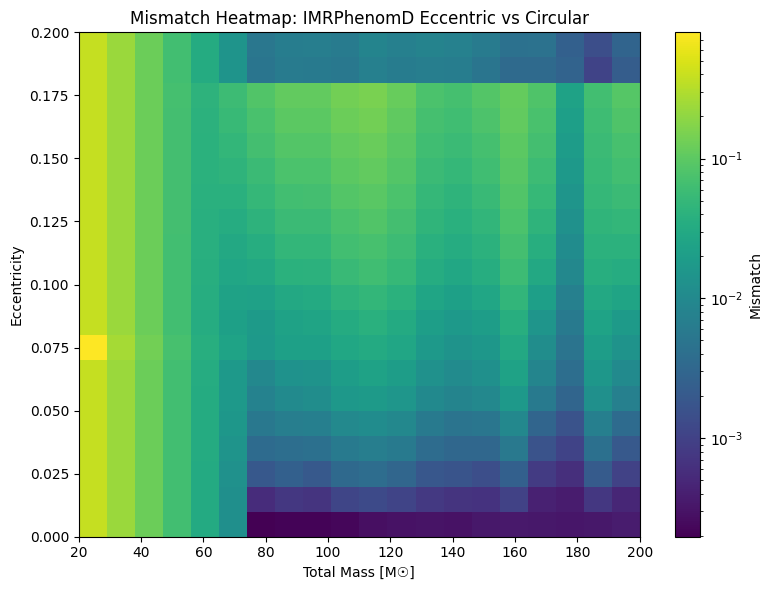

In [24]:
plt.figure(figsize=(8, 6))
plt.imshow(mismatches, origin='lower', aspect='auto',
           extent=[total_masses.min(), total_masses.max(),
                   eccentricities.min(), eccentricities.max()],
           cmap='viridis',
           norm=colors.LogNorm(vmin=np.nanmin(mismatches[mismatches > 0]),  # avoid log(0)
                               vmax=np.nanmax(mismatches)))
plt.colorbar(label="Mismatch")
plt.xlabel("Total Mass [M☉]")
plt.ylabel("Eccentricity")
plt.title("Mismatch Heatmap: IMRPhenomD Eccentric vs Circular")
plt.tight_layout()
plt.show()

In [8]:
q = 1
spin1=(0,0,0)
spin2=(0,0,0)
distance, inclination, coa_phase = 10, 0, 0
f_lower=20

eccentricities = np.linspace(0, 0.2, 20)
total_masses = np.linspace(20, 200, 20)

mismatches = np.zeros((len(eccentricities), len(total_masses)))

for i, e in enumerate(eccentricities):
    for j, M in enumerate(total_masses):
        mass1 = q * M / (q + 1)
        mass2 = M / (q + 1)
        kwargs = {'mass1': mass1, 'mass2': mass2, 'eccentricity': e,
                  'spin1': spin1, 'spin2': spin2,
                  'inclination': inclination, 'distance': distance,
                  'coa_phase': coa_phase, "delta_t": 1.0 / 4096,
                  "f_ref": 20, "f_lower": f_lower}

        seob_ecc = main("SEOBNRv4", [(2, 2)], **kwargs)
        kwargs.pop("eccentricity")
        seob_circ = Waveform.from_model("SEOBNRv4", [(2, 2)], **kwargs)
        mismatches[i, j] = 1 - seob_ecc.match(seob_circ, f_lower)

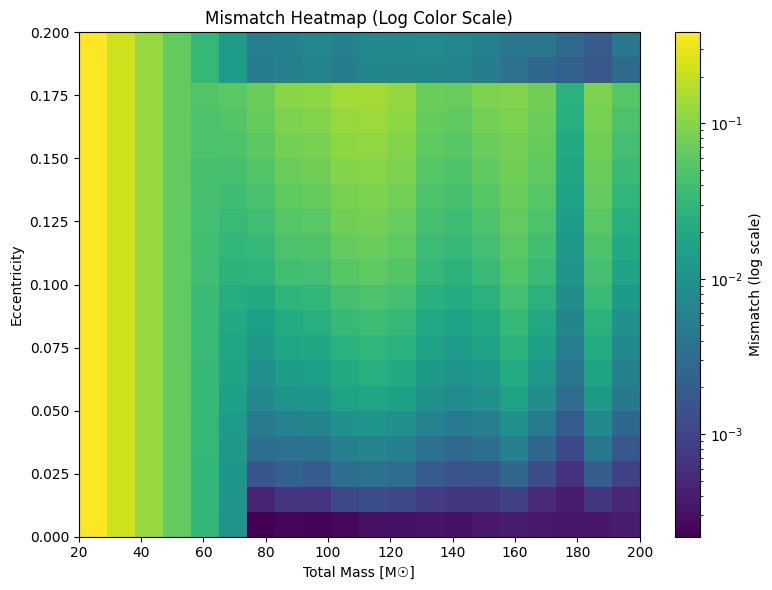

In [9]:
plt.figure(figsize=(8, 6))
plt.imshow(mismatches, origin='lower', aspect='auto',
           extent=[total_masses.min(), total_masses.max(),
                   eccentricities.min(), eccentricities.max()],
           cmap='viridis',
           norm=colors.LogNorm(vmin=np.nanmin(mismatches[mismatches > 0]),  # avoid log(0)
                               vmax=np.nanmax(mismatches)))
plt.colorbar(label="Mismatch (log scale)")
plt.xlabel("Total Mass [M☉]")
plt.ylabel("Eccentricity")
plt.title("Mismatch Heatmap (Log Color Scale)")
plt.tight_layout()
plt.show()

In [25]:
sims = ['SXS:BBH:1358', 'SXS:BBH:1359', 'SXS:BBH:1360', 'SXS:BBH:1361v2.0', 'SXS:BBH:1365', 'SXS:BBH:1366', 'SXS:BBH:1367', 'SXS:BBH:1372']
eccentricities = [0.099, 0.1, 0.142, 0.144, 0.06, 0.095, 0.096, 0.092]
qs = [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0]
masses = np.linspace(25, 150, 14)
distance, inclination, coa_phase = 10, 0, 0
f_lower=25
mismatches = {}

G = 6.67e-11
m = 1.9e30
c = 299792458

for s, eccentricity, q in zip(sims, eccentricities, qs):
    sim = DimensionlessWaveform.from_sim(s)
    
    # q = sim.metadata["q"]   
    spin1=(0,0,0)
    spin2=(0,0,0)

    mismatch_seob, mismatch_phen = [], []
    for total_mass in masses:
        mass1 = q * total_mass / (q + 1)
        mass2 = total_mass / (q + 1)

        # mass1=mass2=25

        newt = units.tM_to_tSI(np.asarray([-1500, -50.4]), total_mass)

        kwargs = {'mass1':mass1,'mass2':mass2,'eccentricity':eccentricity,'spin1':spin1,'spin2':spin2,'inclination':inclination,'distance':distance,'coa_phase':coa_phase,"delta_t": 1.0 / 20000, "f_ref":25, "f_lower":25}

        phen_ecc = main("IMRPhenomD", [(2,2)], **kwargs)
        seob_ecc = main("SEOBNRv4", [(2, 2)],**kwargs)
        dsim = sim.to_Waveform(f_lower, total_mass, distance, inclination, coa_phase)

        f_ISCO = c**3/(6**(3/2)*np.pi*G*total_mass*m)

        # mismatch_phen.append(1-complex_match(dsim, phen_ecc, newt, 4096))
        # mismatch_seob.append(1-complex_match(dsim, seob_ecc, newt, 4096))

        # mismatch_phen.append(1-compute_match(dsim.time, dsim[2,2]*spherical_harmonics(2,2,0,0), phen_ecc.time, phen_ecc[2,2]*spherical_harmonics(2,2,0,0), seob_ecc.time, 4096))
        # mismatch_seob.append(1-compute_match(dsim.time, dsim[2,2]*spherical_harmonics(2,2,0,0), seob_ecc.time, seob_ecc[2,2]*spherical_harmonics(2,2,0,0), seob_ecc.time, 4096))

        mismatch_phen.append(round(1 - phen_ecc.match(dsim, f_lower, f_ISCO), 12))
        mismatch_seob.append(round(1 - seob_ecc.match(dsim, f_lower, f_ISCO), 12))
    mismatches[eccentricity] = (mismatch_phen, mismatch_seob)
#[units.tM_to_tSI(-1500, total_mass), dsim.time[-1]]

Loading SXS simulations using latest tag 'v3.0.0', published at 2025-05-14T18:17:30Z.


/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/sxs/simulations/simulation.py:203: UserWarning: 
Simulation 'SXS:BBH:1361' is deprecated, but you explicitly
requested version 'v2.0', so it is being used.
Pass `ignore_deprecation=True` to quiet this warning.

  warn(message)


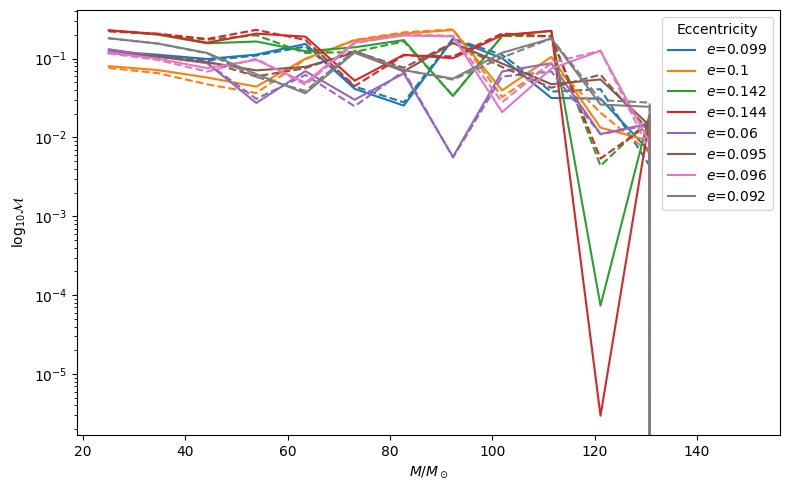

In [26]:
linestyles = {
    "SEOB": "--",
    "Phenom": "-"
}
plt.figure(figsize=(8, 5))
legend_handles = []
for eccentricity, (mismatch_phen, mismatch_seob) in mismatches.items():
    line_phen, = plt.plot(masses, mismatch_phen, linestyle=linestyles["Phenom"])
    plt.plot(masses, mismatch_seob, linestyle=linestyles["SEOB"], color=line_phen.get_color())
    legend_handles.append((line_phen, fr"$e$={eccentricity}"))

plt.legend(*zip(*legend_handles), title="Eccentricity")
plt.yscale("log")
# plt.ylim(1e-5, 7e-1)
plt.xlabel(r"$M/M_\odot$")
plt.ylabel(r"$\text{log}_{10} \mathcal{M}$")
plt.tight_layout()
plt.show()


/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


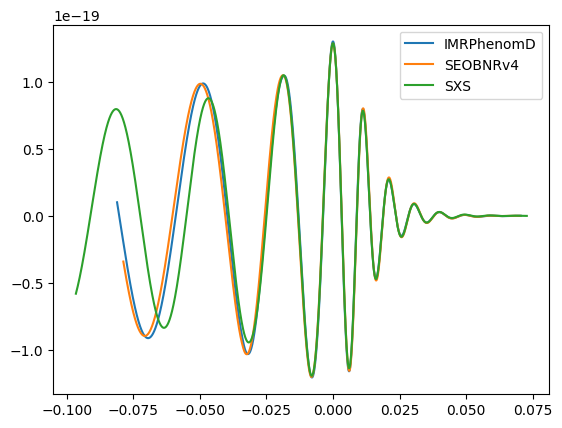

In [27]:
plt.plot(phen_ecc.time, phen_ecc[2,2]*spherical_harmonics(2,2,0,0), label="IMRPhenomD")
plt.plot(seob_ecc.time, seob_ecc[2,2]*spherical_harmonics(2,2,0,0), label="SEOBNRv4")
plt.plot(dsim.time, dsim[2,2]*spherical_harmonics(2,2,0,0), label="SXS")
plt.legend()
plt.show()

In [28]:
compute_match(dsim.time, dsim[2,2]*spherical_harmonics(2,2,0,0), seob_ecc.time, seob_ecc[2,2]*spherical_harmonics(2,2,0,0), [dsim.time[0], seob_ecc.time[-1]], 4096)

np.float64(0.9723048319465634)